In [16]:
# Add lib input sys.path
import os
import sys
import time

import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import math
from sklearn.preprocessing import normalize
from functools import partial
import h5py
from scipy.spatial import distance

nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)

from matplotlib.colors import ListedColormap
import libs.linear_models as lm
import libs.data_util as data
import libs.nn as nn
import libs.plot as myplot
from sklearn import decomposition
from sklearn.model_selection import train_test_split

%matplotlib inline

#### Exercise C.1

* (a) Apply Lagrange multiplier $\lambda$, we have $L= \sum^K_{k=1}N_k\ln w_k + \lambda (\sum_k w_k -1)$, take derivative w.r.t. $w_k$, we have

$\frac{\partial{L}}{\partial{w_k}} = N_k\frac{1}{w_k} + \lambda = 0$, we thus have

$w_k = -\frac{N_k}{\lambda}$

As we have $\sum_k w_k = -\frac{1}{\lambda}\sum_k N_k = -\frac{N}{\lambda} = 1$, so $\lambda = -\frac{1}{N}$ thus $w_k = \frac{N_k}{N}$

* (b) $L_k(X_k; \theta_k) = \sum_{x_n \in X_k} \ln P_k(x_n; \theta_k) = \sum_{x_n \in X_k} -\ln (2\pi)^{\frac{d}{2}}|\Sigma_k|^{\frac{1}{2}} -\frac{1}{2}(x_n-\mu_k)^T\Sigma^{-1}_k (x_n-\mu_k)$

Take derivative w.r.t. $\mu_k$, and set to 0, we have 

\begin{align*}
\frac{\partial{L_k}}{\partial{\mu_k}} &= \sum_{x_n \in X_k} \frac{1}{2} 2\Sigma^{-1}_k (x_n-\mu_k)\\
&= \Sigma^{-1}_k \sum_{x_n \in X_k}  (x_n-\mu_k)\\ 
&= 0\\
\end{align*}

So we have $\mu_k^* = \frac{1}{N_k}\sum_{x_n \in X_k}x_n$

Let $S_k = \Sigma^{-1}_k$, then we have $L_k(X_k; \theta_k) =  \sum_{x_n \in X_k} -\ln (2\pi)^{\frac{d}{2}}|\Sigma_k|^{\frac{1}{2}} -\frac{1}{2}(x_n-\mu_k)^T\Sigma^{-1}_k (x_n-\mu_k) = \sum_{x_n \in X_k} -\ln (2\pi)^{\frac{d}{2}}+ \frac{1}{2} \ln |S| -\frac{1}{2}(x_n-\mu_k)^TS_k (x_n-\mu_k)$


Take derivative w.r.t. $S_k$, and set to 0, we have

\begin{align*}
\frac{\partial{L_k}}{\partial{S_k}} &= \sum_{x_n \in X_k} \frac{1}{2}S^{-1} - \frac{1}{2}(x_n-\mu_k)(x_n-\mu_k)^T\\
&= 0\\ 
\end{align*}

We thus have $(S^{-1})^* =\frac{1}{N_k} \sum_{x_n \in X_k}(x_n-\mu_k)(x_n-\mu_k)^T $

and $\Sigma^*_k = S^{-1}_k = \frac{1}{N_k} \sum_{x_n \in X_k}(x_n-\mu_k)(x_n-\mu_k)^T $


#### Exercise C.2

Solve the equations we have $\hat{\mu}_1 = \frac{1}{2}, \hat{\mu}_2 = 0$

#### Problem C.1

The probability to get a green ball is $P(g) = \frac{1}{2}(1-\mu_1)$, to get a blue ball $P(b) = \frac{1}{2}(1-\mu_2)$ and to get a red ball $P(r) = \frac{1}{2}\mu_1 + \frac{1}{2}\mu_2$, thus the log-likelihood of the incomplete data is

\begin{align*}
\ln \prod P &= \sum \ln P \\
&= N_g\ln P(g) + N_b \ln P(b) + N_r \ln P(r) \\
&= N_g \ln \frac{1}{2}(1-\mu_1) + N_b \ln \frac{1}{2}(1-\mu_2) + N_r \ln( \frac{1}{2}\mu_1 + \frac{1}{2}\mu_2) \\
&= N_g \ln (1-\mu_1) + N_b \ln(1-\mu_2) + N_r \ln( \mu_1 + \mu_2) - N\ln 2\\
\end{align*}

Take derivative w.r.t. $\mu_1,\mu_2$ and set them to zero, we have

$\frac{\partial{L}}{\partial{\mu_1}} = -\frac{N_g}{1-\mu_1} + \frac{N_r}{\mu_1 + \mu_2} = 0$

$\frac{\partial{L}}{\partial{\mu_2}} = -\frac{N_b}{1-\mu_2} + \frac{N_r}{\mu_1 + \mu_2}= 0$

Solve for this we have $\mu_2 = 1-\frac{N_b}{N_g} + \frac{N_b}{N_g}\mu_1$, take this into above equations we have

$\mu_1 = 1 - 2 \frac{N_g}{N}$ and $\mu_2 = 1-2\frac{N_b}{N}$

The likelihood under these values is $L_1 = N_g\ln \frac{N_g}{N} + N_b \ln \frac{N_b}{N} + N_r \ln \frac{N_r}{N}$

Note, the $\mu_1,\mu_2$ are less than 0 when $N_g > \frac{N}{2}$ or $N_b > \frac{N}{2}$, which doesn't make sense. So we need solve constrained maximum likelihood with $\mu_1 \ge 0, \mu_2 \ge 0$. Note, $\mu_1,\mu_2$ are implicitly less than 1 from the log-likelihood formula.

Set $\mu_1=0$ and solve for optimal $\mu_2 = \frac{N_r}{N_r+N_b}$, which corresponds to a likelihood of $L_2 = N_b \ln \frac{N_b}{N_r+N_b} + N_r \ln \frac{N_r}{N_r+N_b} - N\ln 2$

similarly, if we let $\mu_2 = 0$ the optimal $\mu_1 = \frac{N_r}{N_r+N_g}$ and 

$L_3 = N_g \ln \frac{N_g}{N_r+N_g} + N_r \ln \frac{N_r}{N_r+N_g} - N\ln 2$

We need select the maximum likelihood among $L_1,L_2,L_3$, we compute

$L_1 - L_2 = N_g\ln \frac{N_g}{N} + N_b \ln \frac{N_r+N_b}{N} + N_r \ln \frac{N_r + N_b}{N} + N\ln 2 = N\left[\frac{N_g}{N}\ln \frac{N_g}{N} + (1-\frac{N_g}{N})\ln(1-\frac{N_g}{N}) + \ln 2\right]$

Let $x=\frac{N_g}{N}$ we have $L_1 - L_2 = N[x\ln x + (1-x)\ln (1-x) + \ln 2]$

Take derivative w.r.t. $x$ and set it to 0, we see that the derivative is positive when $x>\frac{1}{2}$ and negative when $x<\frac{1}{2}$. Note the difference $L_1 - L_2 = 0$ when $x=\frac{1}{2}$, so we see that $L_1 \ge L_2$ for all values of $\frac{N_g}{N}$. 
Similarly we see that $L_1 \ge L_3$ for all values of $\frac{N_g}{N}$. 

So the maximum likelihhod estimates for $\mu_1, \mu_2$ are

* $\mu_1 = 1 - 2 \frac{N_g}{N}$ and $\mu_2 = 1-2\frac{N_b}{N}$ when $N_g \le \frac{N}{2}$ and $N_b \le \frac{N}{2}$.

* $\mu_1=0, \mu_2 = \frac{N_r}{N_r+N_b}$ when $N_g >\frac{N}{2}$
* $\mu_1=\frac{N_r}{N_r+N_g}, \mu_2 = 0$ when $N_b > \frac{N}{2}$


#### Problem C.2

* (a) Given a red ball, we have 

\begin{align*}
p_1 &= P[Bag 1|red; \hat{\mu_1},\hat{\mu_2}] \\
&= \frac{P[red \Cap Bag 1]}{P[red]}\\
&= \frac{P[red | Bag 1]P[Bag 1]}{P[red]}\\
&= \frac{\hat{\mu_1}\frac{1}{2}}{\frac{1}{2}\hat{\mu_1} + \frac{1}{2}\hat{\mu_2}}\\
&= \frac{\hat{\mu_1}}{\hat{\mu_1} + \hat{\mu_2}}\\
\end{align*}

Similarly we have $p_2 = P[Bag 2|red; \hat{\mu_1},\hat{\mu_2}]  = \frac{\hat{\mu_2}}{\hat{\mu_1} + \hat{\mu_2}}$ given a red ball.

* (b) The probability to get one green ball is $p_g = \frac{1}{2}(1-\mu_1)$, to get $N_g$ green balls, we have $p_g = (\frac{1}{2}(1-\mu_1))^{N_g}$, similarly, we have $p_b = (\frac{1}{2}(1-\mu_2))^{N_b}$ and the probability to get $N_{r_1}$ red balls from bag 1 is $p_{r_1} = (\frac{1}{2}\mu_1)^N_{r_1}$, the probability to get $N_{r_2}$ red balls from bag 2 is $p_{r_2} = (\frac{1}{2}\mu_1)^N_{r_2}$

The log-likelihood of the complete data is thus

$L = N_g\ln (1-\mu_1) + N_b\ln(1-\mu_2) + N_{r_1}\ln \mu_1 + N_{r_2}\ln \mu_2 - N\ln 2$

* (c) Take the expectation w.r.t. $p_1, p_2$ of the log-likelihood, note the green balls and blue balls are known to come from bag 1 and bag 2 respectively. So only $N_{r_1}, N_{r_2}$ are random variables w.r.t. $p_1,p_2$.

$E[N_{r_1}] = p_1N_r, E[N_{r_2}] = p_2N_r$

So the expectation is 

\begin{align*}
Q_t(\mu_1, \mu_2) &=  E[N_g\ln (1-\mu_1) + N_b\ln(1-\mu_2) + N_{r_1}\ln \mu_1 + N_{r_2}\ln \mu_2 - N\ln 2]\\
&= N_g\ln (1-\mu_1) + N_b\ln(1-\mu_2) + E[N_{r_1}] \ln \mu_1 + E[N_{r_2}]\ln \mu_2 - N\ln 2\\
&= N_g\ln (1-\mu_1) + N_b\ln(1-\mu_2) + p_1N_r\ln \mu_1 + p_2N_r\ln \mu_2 - N\ln 2 \\
\end{align*}

* (d) Take derivatives w.r.t. $\mu_1,\mu_2$, and set them to 0, we have

$\frac{\partial{Q_t}}{\partial{\mu_1}} = -\frac{N_g}{1-\mu_1} + \frac{p_1N_r}{\mu_1}$

$\frac{\partial{Q_t}}{\partial{\mu_2}} = -\frac{N_g}{1-\mu_2} + \frac{p_2N_r}{\mu_2}$

Thus $\mu_1 = \frac{p_1N_r}{N_g + p_1N_r}, \mu_2 = \frac{p_bN_r}{N_b + p_2N_r}$

* (e) 

\begin{align*}
\mu_1 &= \frac{p_1N_r}{N_g + p_1N_r} \\
&= \frac{N_r}{\frac{N_g}{p_1} + N_r} \\
&= \frac{N_r}{\frac{N_g}{\frac{\mu_1}{\mu_1 + \mu_2}} + N_r} \\
\end{align*}

Re-arrange the above equation we have $\mu_1(N_r+N_g) + \mu_2N_g =N_r$

Similarly  we have $\mu_2(N_r+N_b) + \mu_1N_b =N_r$

Solve the two equations we have

$\mu_1 = \frac{N-2N_g}{N}, \mu_2 = \frac{N-2N_b}{N}$


#### Problem C.3

* (a) We have 

$P[x=1] = \frac{1}{2}\times 1 + \frac{1}{2}\times \pi = \frac{1+\pi}{2}$

$P[x=0] = \frac{1}{2}\times 0 + \frac{1}{2}\times (1-\pi) = \frac{1-\pi}{2}$

So we have $P[x=x_n] = (\frac{1+\pi}{2})^{x_n}(\frac{1-\pi}{2})^{1-x_n}$

The likelihood is thus

\begin{align*}
P[X|\pi, N] &= \prod^N_{n=1}P[x=x_n]\\
&= \prod^N_{n=1}(\frac{1+\pi}{2})^{x_n}(\frac{1-\pi}{2})^{1-x_n}\\
\end{align*}

Take log, we have the log-likelihood $L = \sum^N_{n=1} x_n \ln (\frac{1+\pi}{2}) + (1-x_n) \ln (\frac{1-\pi}{2})$, take derivative w.r.t. $\pi$ and let it equal to 0, we have

$\sum^N_{n=1} (\frac{x_n}{1+\pi} - \frac{1-x_n}{1-\pi}) = \frac{N_r}{1+\pi} - \frac{N-N_r}{1-\pi}  = 0$, we have $\pi = \frac{2N_r-N}{N}$.

If $N_r < \frac{N}{2}$, $\pi = 0$

For $N_r = 600, N = 1000$, we have $\pi = 0.2$

* (b) The appropriate hidden variable $J$ is the bag membership of each $x_n$.

* (c) Given $\pi, N$, we have $P[x_n, j_n] = P[j_n]P[x_n|j_n] = \frac{1}{2}$ if $j_n \in bag 1$, and $P[x_n, j_n] = \frac{1}{2}\pi $ if $j_n \in bag 2$

Let $N_{r_1} + N_{r_2} = N_r$ where $N_{r_1}$ is the red balls from bag 1 and $N_{r_2}$ is the number of red balls from bag 2. 

The log-likelihood of the complete data is 

$N_{r_1}\ln \frac{1}{2} + N_{r_2} \ln (\frac{\pi}{2}) + N_b \ln (\frac{1-\pi}{2})  = N_{r_2}\ln \pi + N_b \ln (1-\pi) - N\ln 2$

  * (iii) We compute the probability of red ball comes from bag 1, as $p_1 = P[bag 1| red] = \frac{P[bag1, red]}{P[red]} = \frac{P[red|bag 1]P[bag 1]}{P[red]} = \frac{\frac{1}{2}\times 1}{\frac{1}{2}\times 1 + \frac{1}{2}\times \pi_t} = \frac{1}{1+\pi_t}$ 
  
  Similarly, we have $p_2 = \frac{\pi_t}{1+\pi_t}$ 
  
  Take expectation w.r.t. $p_1,p_2$, we have
  
\begin{align*}
Q_t(\pi)&= E\left[N_{r_2}\ln \pi + N_b \ln (1-\pi) - N\ln 2\right]\\
&= E[N_{r_2}]\ln \pi + N_b \ln (1-\pi) - N\ln 2\\
&= p_2N_r\ln \pi + (N-N_r) \ln (1-\pi) - N\ln 2\\
&= \frac{\pi_t}{1+\pi_t}N_r\ln \pi  + (N-N_r) \ln (1-\pi) - N\ln 2\\
\end{align*}

Take derivative of $Q_t(\pi)$ w.r.t $\pi$ and set to 0, we solve for the $\pi_{t+1} = \frac{\pi_tN_r}{\pi_tN_r + (1+\pi_t)(N-N_r)}$

When $N_r \ge \frac{N}{2}$, set $\pi_{t+1} = \pi_t$, we have $\pi_t \to 2\frac{N_r}{N} - 1$

When $N_r < \frac{N}{2}$, we should have $\pi = 0$

  * (v) After we obtain the convergence of E-M, we can compute the probability of $P[j_n = 1]$ using the $\pi$ as the $p_1,p_2$ above.

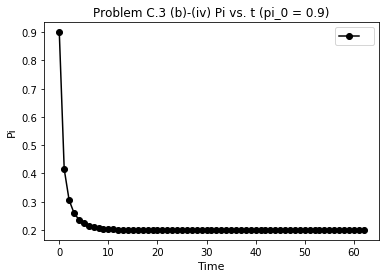

In [22]:
#### Problem C.3

def calc_pis(pi0, Nr, N, maxit = 1000, tol = 1.0e-12):
    pi = math.inf
    itx = 1
    pis = [pi0]
    while itx < maxit:
        r1 = pi0 * Nr
        r2 = r1 + (1+pi0)*(N-Nr)
        pi = r1/r2
        pis.append(pi)
        itx += 1
        if np.abs(pi-pi0) <= tol:
            break
        pi0 = pi
    return pis, itx

Nr = 600
N = 1000
pis_1, itx1 = calc_pis(0.9, Nr, N)
myplot.plt_plot([np.arange(itx1)], [pis_1], 'plot', ['k', 'g', 'r', 'b', 'y'], ['o', 'x', '.', ',', 's'], 
                [' ', '', '', '', ''], 
        title = 'Problem C.3 (b)-(iv) Pi vs. t (pi_0 = 0.9)', yscale = None, ylb = 0, yub = 1.2,
        xlb = None, xub = None, xlabel = 'Time', ylabel = 'Pi',
        legends = ['']*6, legendx = None, legendy = None, marker_sizes=[10]*5) 

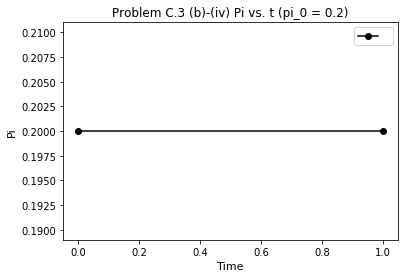

In [21]:
pis_1, itx1 = calc_pis(0.2, Nr, N)
myplot.plt_plot([np.arange(itx1)], [pis_1], 'plot', ['k', 'g', 'r', 'b', 'y'], ['o', 'x', '.', ',', 's'], 
                [' ', '', '', '', ''], 
        title = 'Problem C.3 (b)-(iv) Pi vs. t (pi_0 = 0.2)', yscale = None, ylb = 0, yub = 1.2,
        xlb = None, xub = None, xlabel = 'Time', ylabel = 'Pi',
        legends = ['']*6, legendx = None, legendy = None, marker_sizes=[15]*5) 

#### Problem C.4

* (a) In our assumed model for the temperature, we have $w$ as our parameters. And $y=h(x) + \epsilon = w_0 + w_1x+\epsilon$, $y_n = w_0 +w_1x_n + epsilon ~ N(w_0 + w_1x_n, 1)$ so 

$P[y=y_n|w] = \int P[y=y_n|x=x_n,w]dP[x=x_n] =\int^1_0 dx \frac{1}{\sqrt{2\pi}}e^{-\frac{1}{2}(y_n -w_0 - w_1x)^2}$

Thus the log-likelihood is 

$\ln P[y|w] = \sum^N_{n=1}\ln\left(\int^1_0 dx \frac{1}{\sqrt{2\pi}}e^{-\frac{1}{2}(y_n -w_0 - w_1x)^2}\right)$

* (b) The natural hidden variable $j_n$ will be the time that $x_n$ is measured.

* (c) $P[y, j_n|w] = \frac{1}{\sqrt{2\pi}}e^{-\frac{1}{2}(y_n -w_0 - w_1x_n)^2}$, thus the log-likelihood for the complete data is

$L = \ln P[y, J|w] =  N\ln \frac{1}{\sqrt{2\pi}}  + \sum^N_{n=1} -\frac{1}{2}(y_n -w_0 - w_1x_n)^2 $

* (d) 

\begin{align*}
\gamma_n(x|w) &= P(x_n = x|y_n, w) \\
&= \frac{P(y_n, x_n }{P(y_n}\\
&= \frac{P(y_n| x_n)P(x_n) }{P(y_n}\\
&= \frac{ \frac{1}{\sqrt{2\pi}}e^{-\frac{1}{2}(y_n -w_0 - w_1x_n)^2}}{\int^1_0 dx \frac{1}{\sqrt{2\pi}}e^{-\frac{1}{2}(y_n -w_0 - w_1x)^2}}\\
&= \frac{ e^{-\frac{1}{2}(y_n -w_0 - w_1x)^2}}{\int^1_0 dx e^{-\frac{1}{2}(y_n -w_0 - w_1x)^2}}\\
\end{align*}

We then compute $Q_t(w)$, 

\begin{align*}
Q_t(w) &= E[L] \\
&=E\left[N\ln \frac{1}{\sqrt{2\pi}}  + \sum^N_{n=1} -\frac{1}{2}(y_n -w_0 - w_1x_n)^2\right]\\
&=N\ln \frac{1}{\sqrt{2\pi}} -\frac{1}{2}\sum^N_{n=1} E\left[(y_n -w_0 - w_1x_n)^2\right]\\
&=N\ln \frac{1}{\sqrt{2\pi}}  -\frac{1}{2} \sum^N_{n=1} E\left[(y_n -w_0)^2 - 2(y_n-w_0)w_1x_n+ w^2_1x_n^2\right]\\
&=N\ln \frac{1}{\sqrt{2\pi}}  -\frac{1}{2}\sum^N_{n=1}(y_n -w_0)^2 + \sum^N_{n=1}(y_n-w_0)w_1E[x_n] -\frac{1}{2} \sum^N_{n=1}w^2_1E[x_n^2]\\
&=N\ln \frac{1}{\sqrt{2\pi}}  -\frac{1}{2}\sum^N_{n=1}(y_n -w_0)^2 + w_1\sum^N_{n=1}(y_n-w_0)\alpha_n -\frac{1}{2} w^2_1\sum^N_{n=1}\beta_n\\
&=N\ln \frac{1}{\sqrt{2\pi}}  -\frac{1}{2}\sum^N_{n=1}(y_n -w_0)^2 + w_1\sum^N_{n=1}(y_n-w_0)\alpha_n -\frac{1}{2} w^2_1N\bar{\beta}\\
\end{align*}

* (e) 
Take derivative w.r.t. $w_0,w_1$ and set to 0, we have

\begin{align*}
\frac{\partial{Q_t}}{\partial{w_0}} &= \sum^N_{n=1}(y_n-w_0) - w_1\sum^N_{n=1}\alpha_n \\
\frac{\partial{Q_t}}{\partial{w_1}} &= \sum^N_{n=1}(y_n-w_0)\alpha_n -w_1N\bar{\beta}\\
\end{align*}

Solve the equations we have 

$w_1(t+1) = \frac{\frac{1}{N}\sum^N_{i=1}(y_i-\bar{y})(\alpha_i - \bar{\alpha})}{\bar{\beta}-\bar{\alpha}^2}$

$w_0(t+1) = \bar{y} - w_1(t+1)\bar{\alpha}$

* (f) If the temperature measurement is distrubted according to $P(x)$, then clearly we have

\begin{align*}
\gamma_n(x|w) &= P(x_n = x|y_n, w) \\
&= \frac{P(y_n, x_n }{P(y_n}\\
&= \frac{P(y_n| x_n)P(x_n) }{P(y_n}\\
&= \frac{ P_t(x)\frac{1}{\sqrt{2\pi}}e^{-\frac{1}{2}(y_n -w_0 - w_1x_n)^2}}{\int^1_0 dx P_t(x)\frac{1}{\sqrt{2\pi}}e^{-\frac{1}{2}(y_n -w_0 - w_1x)^2}}\\
&= \frac{ P_t(x)e^{-\frac{1}{2}(y_n -w_0 - w_1x)^2}}{\int^1_0 dx P_t(x)e^{-\frac{1}{2}(y_n -w_0 - w_1x)^2}}\\
\end{align*}


The updates in (e) are unchanged except that they use this new $\gamma_n(x|w_t)$

With $P(x)$, the $P[y, j_n|w] = P(x)\frac{1}{\sqrt{2\pi}}e^{-\frac{1}{2}(y_n -w_0 - w_1x_n)^2}$, 
Let $\hat{N}_k$ be the number of occurance of bump $k$ in the random variable $J$. Let $z_{nk}=1$ if $x_n$ is from bump $k$ and 0 otherwise. 

thus the log-likelihood for the complete data is

$L = \ln P[y, J|w] =  N\ln \frac{1}{\sqrt{2\pi}}  + \sum^K_{k=1}\hat{N}_k\ln P(x) + \sum^N_{n=1} -\frac{1}{2}(y_n -w_0 - w_1x_n)^2 $

The expectation will have an extra term $E[\sum^K_{k=1}\hat{N}_k\ln P(x)] = \ln P(x) \sum^N_{n=1}E[\hat{N}_k] =\sum^N_{n=1} E[\sum^N_{n=1}z_{nk}] \ln P(x) = \sum^N_{n=1} \sum^N_{n=1}\gamma_{nk}\ln P(x) $, 

This achieves maximum when $P(x) = \frac{N_k}{N} = \frac{1}{N}\sum^N_{n=1}\gamma_{n}$

If we maximize the log-likelihood for the incomplete data, we won't be able to separate $P(x)$ from $w$ during our maximization, thus making the problem very hard to solve.